<a href="https://colab.research.google.com/github/oriol33/TFM_OriolGairin/blob/main/run2_Forecast_t1_univ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM Forecast on CISS series**

In [ ]:
#Import libraries
import math
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error
#from keras.engine.sequential import training_utils
#from sklearn.preprocessing import MinMaxScaler

plt.style.use('fivethirtyeight')

In [ ]:
#For saving and loading our model
import os 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content': ['.config', 'drive', 'sample_data']


In [ ]:
# change the OS to use your project folder as the working directory
os.chdir('/content/drive/MyDrive/MESIO/TFM/Models')

In [ ]:
#Comprovation purposes
!touch 'new_file_in_working_directory.txt'

**Upload and preparation of the data**

In [ ]:
#Import files from desktop
from google.colab import files
 
files.upload()  

In [ ]:
#Read csv
euro = pd.read_csv('euro.csv', skiprows=5)
uk = pd.read_csv('uk.csv', skiprows=5)
us = pd.read_csv('us.csv', skiprows=5)
china = pd.read_csv('china.csv', skiprows=5)
germany = pd.read_csv('germany.csv', skiprows=5)
italy = pd.read_csv('italy.csv', skiprows=5)
spain = pd.read_csv('spain.csv', skiprows=5)
portugal = pd.read_csv('portugal.csv', skiprows=5)
france = pd.read_csv('france.csv', skiprows=5)

In [ ]:
# Change column names
euro.columns = ['date', 'value', 'status']
uk.columns = ['date', 'value', 'status']
us.columns = ['date', 'value', 'status']
china.columns = ['date', 'value', 'status', 'comment']
germany.columns = ['date', 'value', 'status', 'comment']
italy.columns = ['date', 'value', 'status']
spain.columns = ['date', 'value', 'status']
portugal.columns = ['date', 'value', 'status']
france.columns = ['date', 'value', 'status']

In [ ]:
uk

,date,value,status
0,2022-09-16,0.2753,Normal value (A)
1,2022-09-15,0.2615,Normal value (A)
2,2022-09-14,0.2571,Normal value (A)
3,2022-09-13,0.2375,Normal value (A)
4,2022-09-12,0.2234,Normal value (A)
...,...,...,...
5750,2000-09-07,0.0308,Normal value (A)
5751,2000-09-06,0.0254,Normal value (A)
5752,2000-09-05,0.0269,Normal value (A)
5753,2000-09-04,0.0331,Normal value (A)


In [ ]:
#Reverse data frame (so that first observation is the oldest)
euro = euro.loc[::-1].reset_index(drop=True)
uk = uk.loc[::-1].reset_index(drop=True)
us = us.loc[::-1].reset_index(drop=True)
china = china.loc[::-1].reset_index(drop=True)
germany = germany.loc[::-1].reset_index(drop=True)
italy = italy.loc[::-1].reset_index(drop=True)
spain = spain.loc[::-1].reset_index(drop=True)
portugal = portugal.loc[::-1].reset_index(drop=True)
france = france.loc[::-1].reset_index(drop=True)

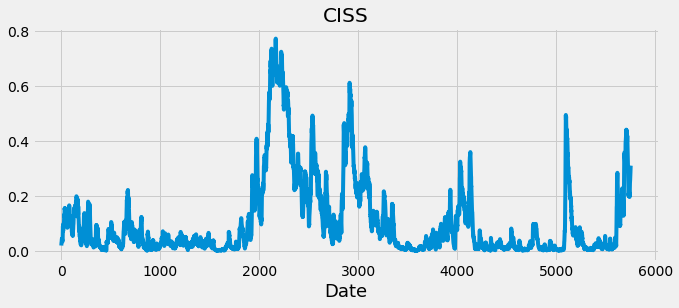

In [ ]:
#Plot
plt.figure(figsize=(10,4))
plt.title("CISS")
plt.plot(france['value'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('', fontsize=18)
plt.show()

In [ ]:
#Select value column
euro = euro.filter(['value'])
uk = uk.filter(['value'])
us = us.filter(['value'])
china = china.filter(['value'])
germany = germany.filter(['value'])
italy = italy.filter(['value'])
spain = spain.filter(['value'])
portugal = portugal.filter(['value'])
france = france.filter(['value'])

#Convert dataframe to numpy
euro = euro.values
uk = uk.values
us = us.values
china = china.values
germany = germany.values
italy = italy.values
spain = spain.values
portugal = portugal.values
france = france.values

In [ ]:
france.shape , china.shape , len(euro)

((5755, 1), (4160, 1), 5755)

In [ ]:
#Partitions for Train + Validation + Test
#train_pct = 0.75
#valid_pct = 0.15
#test_pct = 0.10

training_data_len = 4320
valid_data_len = 860

#Hyperparamether sequence_length (prediction at t+1 by using previous 'sequence_length' days)
sequence_length = 64

In [ ]:
#Create the Train , Validation & Test datasets (for now, we exclude china)
train_euro = euro[0:training_data_len, :]
train_uk = uk[0:training_data_len, :]
train_us = us[0:training_data_len, :]
train_germany = germany[0:training_data_len, :]
train_italy = italy[0:training_data_len, :]
train_spain = spain[0:training_data_len, :]
train_portugal = portugal[0:training_data_len, :]
train_france = france[0:training_data_len, :]

valid_euro = euro[training_data_len:(training_data_len+valid_data_len), :]
valid_uk = uk[training_data_len:(training_data_len+valid_data_len), :]
valid_us = us[training_data_len:(training_data_len+valid_data_len), :]
valid_germany = germany[training_data_len:(training_data_len+valid_data_len), :]
valid_italy = italy[training_data_len:(training_data_len+valid_data_len), :]
valid_spain = spain[training_data_len:(training_data_len+valid_data_len), :]
valid_portugal = portugal[training_data_len:(training_data_len+valid_data_len), :]
valid_france = france[training_data_len:(training_data_len+valid_data_len), :]

test_euro = euro[(training_data_len+valid_data_len):-3 , :]
test_uk = uk[(training_data_len+valid_data_len):-3 , :]
test_us = us[(training_data_len+valid_data_len):-3 , :]
test_germany = germany[(training_data_len+valid_data_len):-3 , :]
test_italy = italy[(training_data_len+valid_data_len):-3 , :]
test_spain = spain[(training_data_len+valid_data_len):-3 , :]
test_portugal = portugal[(training_data_len+valid_data_len):-3 , :]
test_france = france[(training_data_len+valid_data_len):-3 , :]

In [ ]:
print(train_euro.shape ,valid_euro.shape, test_euro.shape)

(4320, 1) (860, 1) (572, 1)


In [ ]:
#Create function to compute x_train and y_train sequences (x: input & y:output).
def seq_fun(train_data, valid_data, test_data):
  x_train = []
  y_train = []
  x_valid = []
  y_valid = []
  x_test = []  
  y_test = []

  for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[(i-sequence_length):i, 0])
    y_train.append(train_data[i,0])

  for i in range(sequence_length, len(valid_data)):
    x_valid.append(valid_data[(i-sequence_length):i, 0])
    y_valid.append(valid_data[i,0])

  for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[(i-sequence_length):i, 0])
    y_test.append(test_data[i,0])

  x_train, y_train, x_valid, y_valid, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_valid) , np.array(y_valid), np.array(x_test), np.array(y_test)
  return(x_train, y_train, x_valid, y_valid, x_test, y_test)

In [ ]:
#Obtain sequences on our datasets
train_euro_x , train_euro_y, valid_euro_x, valid_euro_y, test_euro_x, test_euro_y = seq_fun(train_euro, valid_euro, test_euro) 
train_uk_x , train_uk_y, valid_uk_x, valid_uk_y, test_uk_x, test_uk_y = seq_fun(train_uk, valid_uk, test_uk) 
train_us_x , train_us_y, valid_us_x, valid_us_y, test_us_x, test_us_y = seq_fun(train_us, valid_us, test_us)
train_germany_x , train_germany_y, valid_germany_x, valid_germany_y, test_germany_x, test_germany_y = seq_fun(train_germany, valid_germany, test_germany)
train_italy_x , train_italy_y, valid_italy_x, valid_italy_y, test_italy_x, test_italy_y = seq_fun(train_italy, valid_italy, test_italy)
train_spain_x , train_spain_y, valid_spain_x, valid_spain_y, test_spain_x, test_spain_y = seq_fun(train_spain, valid_spain, test_spain)
train_portugal_x , train_portugal_y, valid_portugal_x, valid_portugal_y, test_portugal_x, test_portugal_y = seq_fun(train_portugal, valid_portugal, test_portugal)
train_france_x , train_france_y, valid_france_x, valid_france_y, test_france_x, test_france_y = seq_fun(train_france, valid_france, test_france)  

In [ ]:
#Make sure of the correct shape dimensions
print(train_euro_x.shape , train_euro_y.shape, valid_euro_x.shape, valid_euro_y.shape, test_euro_x.shape, test_euro_y.shape)
print(train_france_x.shape , train_france_y.shape, valid_france_x.shape, valid_france_y.shape, test_france_x.shape, test_france_y.shape)

(4256, 64) (4256,) (796, 64) (796,) (508, 64) (508,)
(4256, 64) (4256,) (796, 64) (796,) (508, 64) (508,)


**LSTM network building and training**

Our approach consists on using all train_datasets (from all countries) to train one unique LSTM network that generalizes the properties of the CISS indices. We do so because of the lack of large amounts of data and the need for a data augmentation method to avoid overfitting.

Precisely, we will have 3 LSTM networks, one for each horizon t+h|t of prediction.

**Approach 1:** Concadenate training sequences. Simplest approach (LSTM benchmark). Take batch_size=1 so that internal state is reset for every sequence within the epoch. No hyperparameter tunning optimization technique (just balanced "common sense" choice of hyperparamethers).

**Approach 2:** Concadenate training sequences. The input in the model should be ordered in time. We give the model the ability to remember its internal state during the training sequences within each country. After, we reset its internal state. No hyperparameter tunning optimization technique (just balanced "common sense" choice of hyperparamethers).

**Approach 3:** Bayesian Optimization of the hyperparameter space. 

In [ ]:
#Create function to compute x_train and y_train sequences (x: input & y:output).
def reshaping(train_data_x):
  reshaped_data = np.reshape(train_data_x, (train_data_x.shape[0], train_data_x.shape[1], 1))
  return(reshaped_data)

In [ ]:
#Reshape the data to fit to LSTM. You have to input 3d array (number of samples, number of timesteps, number of features).
train_euro_x = reshaping(train_euro_x)
train_uk_x = reshaping(train_uk_x)
train_us_x = reshaping(train_us_x)
train_germany_x = reshaping(train_germany_x)
train_italy_x = reshaping(train_italy_x)
train_spain_x = reshaping(train_spain_x)
train_portugal_x = reshaping(train_portugal_x)
train_france_x = reshaping(train_france_x)

valid_euro_x = reshaping(valid_euro_x)
valid_uk_x = reshaping(valid_uk_x)
valid_us_x = reshaping(valid_us_x)
valid_germany_x = reshaping(valid_germany_x)
valid_italy_x = reshaping(valid_italy_x)
valid_spain_x = reshaping(valid_spain_x)
valid_portugal_x = reshaping(valid_portugal_x)
valid_france_x = reshaping(valid_france_x)

train_euro_x.shape, train_us_x.shape, valid_euro_x.shape

((4256, 64, 1), (4256, 64, 1), (796, 64, 1))

**Hyperparameters and tunning possibilities**: 

*   Arquitectura del modelo: layers y unidades por layer (Ratio #secuencias/#param. tiene que ser razonable).
*   Sequence length: How many timesteps is our input composed of.
*   Batch_size: number of samples to work through before updating the internal model parameters (number of samples processed before the model is updated).
*   Epochs: number times that the learning algorithm will work through the entire training dataset (the number of complete passes through the training dataset).
*   Optimizer (choice of optimizer: Adam preferred choice overall; choice of learning rate)
*   Loss function (define loss function)
*   Early stoping (min_delta and patience)
*   Dropout regularization (dropout: Fraction of the units to drop for the linear transformation of the inputs; recurrent_dropout: Fraction of the units to drop for the linear transformation of the recurrent state.)

By default, an LSTM layer in Keras maintains state between data within one batch. ***If*** our tarining data is not ordered in time, ***then*** we might choose batch size=1 (or multiple length of the samples of one country). The nb. of epochs will depend upon when the loss function is stabilized.

By default, the samples within an epoch are shuffled prior to being exposed to the network. ***If*** we want the network to build up state as it learns across the sequence of observations, ***then*** we should disable the shuffling of samples by setting “shuffle” to “False“.

---
**To do list**

(Empty)

---
**Benchmark comparison**
T+1|T (only on germany CISS)

*   Naive approach: 0.0001052777
*   Arma: 8.704908e-05 (0.00008704908)
*   Relative Gain: 17.31%






In [ ]:
#Build the LSTM model    (stateful_model_t1_univ.h5)
#Architecture:
#   -Input: 1 feature at a time, of a sequence of length 'sequence_length'
#   -Hidden layers: ...
#   -Output: 1 output (returns a value, the univariate forecast for one of the time series)

#Total number of parameters:
# LSTM layer:  i: num. of input features ; h: number of hidden units => 4hi + 4h + 4hh parameters

#batch_size = 4 #batch size

#model = Sequential()
#model.add(LSTM(12, return_sequences=True, batch_input_shape=(batch_size, train_euro_x.shape[1], train_euro_x.shape[2]), stateful=True))
#model.add(LSTM(6, return_sequences=False, dropout=0.05, recurrent_dropout=0.05, stateful=True))
#model.add(Dense(1))

In [ ]:
#Build the LSTM model
#Architecture:
#   -Input: 1 feature at a time, of a sequence of length 'sequence_length'
#   -Hidden layers: ...
#   -Output: 1 output (returns a value, the univariate forecast for one of the time series)

#Total number of parameters:
# LSTM layer:  i: num. of input features ; h: number of hidden units => 4hi + 4h + 4hh parameters

batch_size = 4 #batch size

model = Sequential()
model.add(LSTM(12, return_sequences=False, batch_input_shape=(batch_size, train_euro_x.shape[1], train_euro_x.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (4, 12)                   672       
                                                                 
 dense (Dense)               (4, 1)                    13        
                                                                 
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Choose hyperparameters
batch_size = 4 #batch size
epochs = 50  #epochs (maximum training duration)
loss_f = tf.keras.losses.MeanSquaredError()  #loss function
lr = 0.0001 #learning rate
opti = tf.keras.optimizers.Adam(learning_rate=lr)  #optimizer
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-7, patience=12, verbose=1, restore_best_weights=True)]   #early stopping (define min_delta and patience periods)

In [ ]:
#Compile the model
model.compile(optimizer=opti, loss=loss_f, metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
#Define model training and state reset points
def training(nb_epoch):
  for i in range(nb_epoch):
    model.fit(train_euro_x, train_euro_y, batch_size=batch_size, epochs=1, validation_data=(valid_euro_x, valid_euro_y), callbacks=callbacks, shuffle=False)
    model.reset_states()
   
    model.fit(train_uk_x, train_uk_y, batch_size=batch_size, epochs=1, validation_data=(valid_uk_x, valid_uk_y), callbacks=callbacks, shuffle=False)
    model.reset_states()
   
    model.fit(train_us_x, train_us_y, batch_size=batch_size, epochs=1, validation_data=(valid_us_x, valid_us_y), callbacks=callbacks, shuffle=False)
    model.reset_states()

    model.fit(train_germany_x, train_germany_y, batch_size=batch_size, epochs=1, validation_data=(valid_germany_x, valid_germany_y), callbacks=callbacks, shuffle=False)
    model.reset_states()

    model.fit(train_italy_x, train_italy_y, batch_size=batch_size, epochs=1, validation_data=(valid_italy_x, valid_italy_y), callbacks=callbacks, shuffle=False)
    model.reset_states()

    model.fit(train_spain_x, train_spain_y, batch_size=batch_size, epochs=1, validation_data=(valid_spain_x, valid_spain_y), callbacks=callbacks, shuffle=False)
    model.reset_states()

    model.fit(train_portugal_x, train_portugal_y, batch_size=batch_size, epochs=1, validation_data=(valid_portugal_x, valid_portugal_y), callbacks=callbacks, shuffle=False)
    model.reset_states()

    model.fit(train_france_x, train_france_y, batch_size=batch_size, epochs=1, validation_data=(valid_france_x, valid_france_y), callbacks=callbacks, shuffle=False)
    model.reset_states()
  return model

In [ ]:
stateful_model = training(nb_epoch=epochs)

1064/1064 [==============================] - 20s 19ms/step - loss: 1.0517e-04 - mean_absolute_error: 0.0066 - val_loss: 4.1635e-05 - val_mean_absolute_error: 0.0032


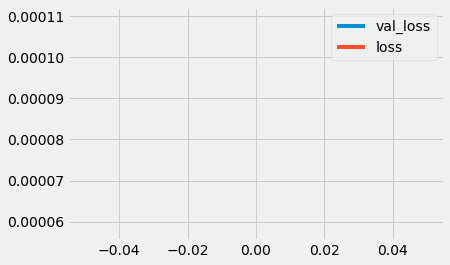

In [ ]:
#Loss per epoch
#history.history Contains the loss and metrics per epoch
loss_per_epoch= stateful_model.history.history['loss']
val_loss_per_epoch = stateful_model.history.history['val_loss']
plt.plot(range(len(val_loss_per_epoch)), val_loss_per_epoch, label="val_loss")
plt.plot(range(len(loss_per_epoch)), loss_per_epoch, label = "loss")
plt.legend()
plt.show()

**Save & load the model**

In [ ]:
#Save the model
stateful_model.save("stateful_model_v3_t1_univ.h5")

In [ ]:
#Load the model
#stateful_model = keras.models.load_model("stateful_model_t1_univ.h5")
stateful_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (4, 16)                   1152      
                                                                 
 dense_2 (Dense)             (4, 1)                    17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Save the model
#model.save('/content/drive/MyDrive/MESIO/TFM/Models')

In [ ]:
#Load the model
#model = keras.models.load_model('/content/drive/MyDrive/MESIO/TFM/Models')
#model.summary()

**Evaluate by country**

In [ ]:
predictions_euro = stateful_model.predict(reshaping(test_euro_x), batch_size=4)
predictions_uk = stateful_model.predict(reshaping(test_uk_x), batch_size=4)
predictions_us = stateful_model.predict(reshaping(test_us_x), batch_size=4)
predictions_germany = stateful_model.predict(reshaping(test_germany_x), batch_size=4)
predictions_italy = stateful_model.predict(reshaping(test_italy_x), batch_size=4)
predictions_spain = stateful_model.predict(reshaping(test_spain_x), batch_size=4)
predictions_portugal = stateful_model.predict(reshaping(test_portugal_x), batch_size=4)
predictions_france = stateful_model.predict(reshaping(test_france_x), batch_size=4)

127/127 [==============================] - 0s 3ms/step


In [ ]:
#Model performance:
pred = predictions_portugal #choose country
actual = test_portugal_y    #choose country

mse = mean_squared_error(pred, actual)
mae = mean_absolute_error(pred, actual)

print('MSE: %.9f' % mse)
print('MAE: %.9f' % mae)

MSE: 0.000038494
MAE: 0.003824843


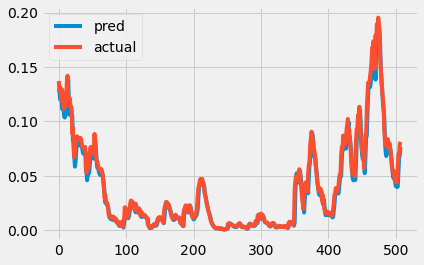

In [ ]:
# Plot the predictions
plt.plot(range(len(pred)), pred, label="pred")
plt.plot(range(len(actual)), actual, label = "actual")
plt.legend()
plt.show()